In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
%pylab inline

#read files
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

#combine datasets
train['file']='train'
test['file']='test'
data = pd.concat([train, test],ignore_index=True, sort=True)
data.head()

Populating the interactive namespace from numpy and matplotlib


/Users/trevor/python-projects/analytics/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy



,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,file
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


# DATA EXPLORATION

In [2]:
data.shape

(14204, 13)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  11765 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  10188 non-null object
Outlet_Type                  14204 non-null object
file                         14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.4+ MB


In [4]:
data.Item_Weight.isnull().sum()

2439

In [5]:
data.Outlet_Size.isnull().sum()

4016

#### Item_Weight and Outlet_Size have null values

In [6]:
data.Item_Type.value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

In [7]:
data.Item_Fat_Content.value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [8]:
data.Outlet_Location_Type.value_counts()

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

In [9]:
data.Outlet_Size.value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [10]:
data.Outlet_Type.value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

#### Item_Fat_Content dimension has miscoded values

In [11]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


#### Item_Visibility has min value of 0

In [12]:
data[data['Item_Visibility'] == 0].count()['Item_Visibility']

879

# DATA CLEANING

#### Impute average item weight for null values of Item_Weight dimension

In [13]:
data.Item_Weight.isnull().sum()

2439

In [14]:
#Item_Weight null values to average weight per item
item_weight_avg = data.pivot_table(values='Item_Weight', index='Item_Identifier')
item_weight_nulls = data['Item_Weight'].isnull()
data.loc[item_weight_nulls,'Item_Weight'] = data.loc[item_weight_nulls,'Item_Identifier'].apply(lambda x: item_weight_avg.loc[x].values[0])

In [15]:
data.Item_Weight.isnull().sum()

0

#### Impute most common values of Outlet_Type and Outlet_Location_Type for null values of Outlet_Size dimension

In [16]:
data.Outlet_Size.isnull().sum()

4016

In [17]:
outlet_type_by_size = pd.crosstab(data['Outlet_Size'],data['Outlet_Type'])
outlet_type_by_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,1553,0,0
Medium,0,1550,1546,1559
Small,880,3100,0,0


In [18]:
df = pd.DataFrame({'count':data.groupby(['Outlet_Size','Outlet_Type']).size()}).reset_index()
df

,Outlet_Size,Outlet_Type,count
0,High,Supermarket Type1,1553
1,Medium,Supermarket Type1,1550
2,Medium,Supermarket Type2,1546
3,Medium,Supermarket Type3,1559
4,Small,Grocery Store,880
5,Small,Supermarket Type1,3100


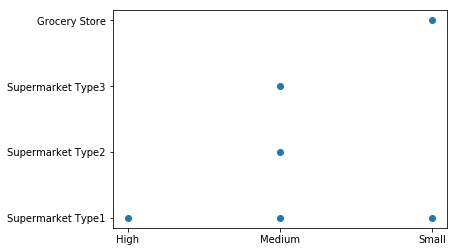

In [19]:
plt.scatter(df['Outlet_Size'],df['Outlet_Type'])
plt.show()

In [20]:
mapping = {'Grocery Store':'Small'}
mapping2 = data.Outlet_Type.map(mapping)
data['Outlet_Size'] = data.Outlet_Size.combine_first(mapping2)

In [21]:
data.Outlet_Size.isnull().sum()

3091

In [22]:
outlet_location_by_size = pd.crosstab(data['Outlet_Size'],data['Outlet_Location_Type'])
outlet_location_by_size

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,1553
Medium,1550,0,3105
Small,2430,1550,925


In [23]:
df = pd.DataFrame({'count':data.groupby(['Outlet_Size','Outlet_Location_Type']).size()}).reset_index()
df

,Outlet_Size,Outlet_Location_Type,count
0,High,Tier 3,1553
1,Medium,Tier 1,1550
2,Medium,Tier 3,3105
3,Small,Tier 1,2430
4,Small,Tier 2,1550
5,Small,Tier 3,925


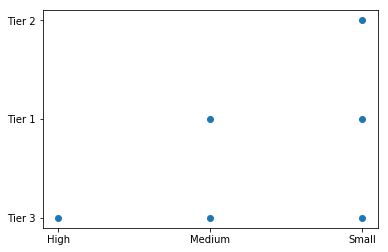

In [24]:
plt.scatter(df['Outlet_Size'],df['Outlet_Location_Type'])
plt.show()

In [25]:
mapping3 = {'Tier 2':'Small'}
mapping4 = data.Outlet_Location_Type.map(mapping3)
data['Outlet_Size'] = data.Outlet_Size.combine_first(mapping4)

In [26]:
data.Outlet_Size.isnull().sum()

0

#### Impute average item visibility for values equal to 0 of Item_Visibility dimension

In [27]:
data[data['Item_Visibility'] == 0].count()['Item_Visibility']

879

In [28]:
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')
miss_bool = (data['Item_Visibility'] == 0)
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x].values[0])

In [29]:
data[data['Item_Visibility'] == 0].count()['Item_Visibility']

0

#### Correct miscoded values in Item_Fat_Content

In [30]:
Item_Fat_Content_Counts = pd.DataFrame({'count':data.groupby(['Item_Fat_Content']).size()}).reset_index()
Item_Fat_Content_Counts

,Item_Fat_Content,count
0,LF,522
1,Low Fat,8485
2,Regular,4824
3,low fat,178
4,reg,195


In [31]:
data['Item_Fat_Content'].replace(['low fat','LF','reg'],['Low Fat','Low Fat','Regular'], inplace=True)
Item_Fat_Content_Counts = pd.DataFrame({'count':data.groupby(['Item_Fat_Content']).size()}).reset_index()
Item_Fat_Content_Counts

,Item_Fat_Content,count
0,Low Fat,9185
1,Regular,5019


# FEATURE ENGINEERING

#### Create Item_Type_Avg_Sale dimension for average sale of Item_Type dimension

In [32]:
data.Item_Outlet_Sales.isnull().sum()

5681

In [33]:
#Item_Weight null values to average weight per item
item_outlet_sales_avg = data.pivot_table(values='Item_Outlet_Sales', index='Item_Identifier')
item_outlet_sales_nulls = data['Item_Outlet_Sales'].isnull()
data.loc[item_outlet_sales_nulls,'Item_Outlet_Sales'] = data.loc[item_outlet_sales_nulls,'Item_Identifier'].apply(lambda x: item_outlet_sales_avg.loc[x].values[0])

In [ ]:
data.Item_Outlet_Sales.isnull().sum()

In [34]:
df = pd.DataFrame(data.groupby('Item_Type')['Item_Outlet_Sales'].mean()/data.groupby(['Item_Type']).size())
df.columns = ['Item_Outlet_Sales']
df

,Item_Outlet_Sales
Item_Type,
Baking Goods,1.798513
Breads,5.268198
Breakfast,10.806165
Canned,2.046530
Dairy,1.968726
Frozen Foods,1.479647
Fruits and Vegetables,1.125341
Hard Drinks,5.966682
Health and Hygiene,2.354210


In [36]:
df_to_dict = dict(zip(df.index, df.Item_Outlet_Sales))
df_to_dict

{'Baking Goods': 1.7985130018505004,
 'Breads': 5.26819789667726,
 'Breakfast': 10.806164912500222,
 'Canned': 2.0465303665445034,
 'Dairy': 1.968725865674779,
 'Frozen Foods': 1.4796470906559618,
 'Fruits and Vegetables': 1.1253411704192489,
 'Hard Drinks': 5.966682219974092,
 'Health and Hygiene': 2.354209828326304,
 'Household': 1.4626070226260535,
 'Meat': 2.959096659887693,
 'Others': 6.912434758260448,
 'Seafood': 26.022123021263546,
 'Snack Foods': 1.1467945134931412,
 'Soft Drinks': 2.8458904766982074,
 'Starchy Foods': 9.122542332860174}

In [37]:
data['Item_Type_Avg_Sale'] = data['Item_Type'].map(df_to_dict)
df = pd.DataFrame({'count':data.groupby(['Item_Type','Item_Type_Avg_Sale']).size()}).reset_index()
df

,Item_Type,Item_Type_Avg_Sale,count
0,Baking Goods,1.798513,1086
1,Breads,5.268198,416
2,Breakfast,10.806165,186
3,Canned,2.046530,1084
4,Dairy,1.968726,1136
5,Frozen Foods,1.479647,1426
6,Fruits and Vegetables,1.125341,2013
7,Hard Drinks,5.966682,362
8,Health and Hygiene,2.354210,858
9,Household,1.462607,1548


#### Create Item_Type_Sale_Frequency dimension for sale frequency of Item_Type dimension

In [38]:
(data['Item_Type'].value_counts()/data['Item_Type'].count())*100

Fruits and Vegetables    14.172064
Snack Foods              14.003098
Household                10.898338
Frozen Foods             10.039426
Dairy                     7.997747
Baking Goods              7.645734
Canned                    7.631653
Health and Hygiene        6.040552
Meat                      5.181639
Soft Drinks               5.111236
Breads                    2.928752
Hard Drinks               2.548578
Others                    1.971276
Starchy Foods             1.893833
Breakfast                 1.309490
Seafood                   0.626584
Name: Item_Type, dtype: float64

In [39]:
df = pd.DataFrame((data['Item_Type'].value_counts()/data['Item_Type'].count())*100)
df.columns = ['Item_Type_Sale_Frequency']
df

,Item_Type_Sale_Frequency
Fruits and Vegetables,14.172064
Snack Foods,14.003098
Household,10.898338
Frozen Foods,10.039426
Dairy,7.997747
Baking Goods,7.645734
Canned,7.631653
Health and Hygiene,6.040552
Meat,5.181639
Soft Drinks,5.111236


In [40]:
df_to_dict = dict(zip(df.index, df.Item_Type_Sale_Frequency))
df_to_dict

{'Baking Goods': 7.645733596170093,
 'Breads': 2.928752464094621,
 'Breakfast': 1.309490284426922,
 'Canned': 7.63165305547733,
 'Dairy': 7.997747113489158,
 'Frozen Foods': 10.039425513939735,
 'Fruits and Vegetables': 14.172064207265558,
 'Hard Drinks': 2.548577865390031,
 'Health and Hygiene': 6.040551957195156,
 'Household': 10.898338496198253,
 'Meat': 5.181638974936638,
 'Others': 1.9712756969867642,
 'Seafood': 0.6265840608279358,
 'Snack Foods': 14.003097718952407,
 'Soft Drinks': 5.1112362714728246,
 'Starchy Foods': 1.89383272317657}

In [41]:
data['Item_Type_Sale_Frequency'] = data['Item_Type'].map(df_to_dict)
df = pd.DataFrame({'count':data.groupby(['Item_Type','Item_Type_Sale_Frequency']).size()}).reset_index()
df

,Item_Type,Item_Type_Sale_Frequency,count
0,Baking Goods,7.645734,1086
1,Breads,2.928752,416
2,Breakfast,1.309490,186
3,Canned,7.631653,1084
4,Dairy,7.997747,1136
5,Frozen Foods,10.039426,1426
6,Fruits and Vegetables,14.172064,2013
7,Hard Drinks,2.548578,362
8,Health and Hygiene,6.040552,858
9,Household,10.898338,1548


#### Create new dimension for number of years stores have been open

In [42]:
data['Years_Open'] = 2013 - data['Outlet_Establishment_Year']
data['Years_Open'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Years_Open, dtype: float64

In [43]:
data.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
file                          object
Item_Type_Avg_Sale           float64
Item_Type_Sale_Frequency     float64
Years_Open                     int64
dtype: object

#### One Hot Coding Categorical Dimensions

In [44]:
le = LabelEncoder()
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Size','Outlet_Type']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

data = pd.get_dummies(data, columns=['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Size','Outlet_Type'])

In [45]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
file                          object
Item_Type_Avg_Sale           float64
Item_Type_Sale_Frequency     float64
Years_Open                     int64
Outlet                         int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Type_0                    uint8
Item_Type_1                    uint8
Item_Type_2                    uint8
Item_Type_3                    uint8
Item_Type_4                    uint8
Item_Type_5                    uint8
Item_Type_6                    uint8
Item_Type_7                    uint8
Item_Type_8                    uint8
Item_Type_9                    uint8
Item_Type_10                   uint8
Item_Type_11                   uint8
Item_Type_12                   uint8
I

# EXPORT MANIPULATED DATA

In [46]:
#Split back into test and train files
train = data.loc[data['file']=="train"]
test = data.loc[data['file']=="test"]

In [47]:
#Drop dimensions not needed
test.drop(['Outlet_Establishment_Year','Item_Outlet_Sales','file'],axis=1,inplace=True)
train.drop(['Outlet_Establishment_Year','file'],axis=1,inplace=True)

In [48]:
#Export modified files to csv
train.to_csv("data/train_modified.csv",index=False)
test.to_csv("data/test_modified.csv",index=False)